<h4>Packages imports:</h4>
<p>Packages used frequently are imported here. When a package is used only once or infrequently, the import is done inline.<p>
<p>If running locally, ensure the a virtual environment with all dependencies has been setup: see README.md</p>

In [1]:
import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

<h4>Global Data Lab (GDL):</h4>
<p>The following dataframes will be prepared in this section:</p>
<ul>
    <li>Global shapefile</li>
    <li>Subnational poverty (iwi) and other socio-economic indicators</li>
    <ul>
        <li>Appended to GDL dataframe: annual Chinese steel production (source: World Steel Association)</li>
    </ul>
</ul>
<h5>Shapefiles:</h5>
<p>The geocoded dataset of Chinese development projects will be merged with data from the <a href="https://globaldatalab.org/areadata">Global Data Lab (GDL)</a> using shapefiles available on GDL. Some corrections to the available shapefiles has been made using QGIS (this process is currently undocumented).</p>

,GDLCode,iso_code,country,region,geometry,Continent
0,GRDt,GRD,Grenada,Total,"MULTIPOLYGON (((-61.78597 11.98903, -61.78597 ...",NCA
1,PRIt,PRI,Peurto Rico,None,"MULTIPOLYGON (((-66.92847 17.94347, -66.92958 ...",NCA
2,VCTt,VCT,Saint Vincent and the Grenadin,Total,"MULTIPOLYGON (((-61.43930 12.61625, -61.43930 ...",NCA
3,PANr109,PAN,Panama,Veraguas,"MULTIPOLYGON (((-81.78597 7.26486, -81.80236 7...",NCA
4,CHEr103,CHE,Switzerland,Northwestern Switzerland,"POLYGON ((7.42522 47.45184, 7.43007 47.45928, ...",EU


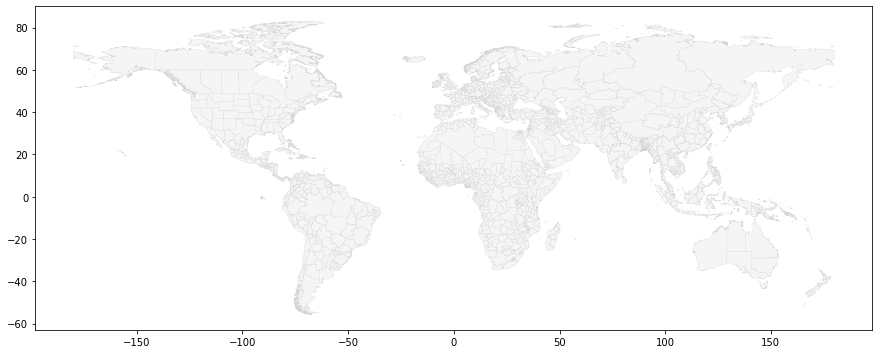

In [2]:
gdl_shp = gpd.read_file('shapefiles/GDL-SHP-Clean-v3.shp')
geonames1 = pd.read_csv('geonames.csv', index_col=0)[['ISO-3166alpha3', 'Continent']].copy()
geonames1.rename(columns={'ISO-3166alpha3':'iso_code'}, inplace=True)
gdl_shp = pd.merge(gdl_shp, geonames1[['iso_code', 'Continent']], how="left", on='iso_code')
display(gdl_shp.head())
display(gdl_shp.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.25))

<h5>Global Data Lab (GDL) subnational socio-economic indicators:</h5>
<p>Variables from GDL are were downloaded in .csv format, each file contains a single indicator for each subnational region and year. Values are inter- & extrapolated to 3 years.</p>
<p>The files are merged into a single dataframe, the time period is reduced to 1998-2018 and countries without Chinese projects are removed. Resulting in a data covering:</p>
<ul>
    <li>1202 (1194) subnational regions within;</li>
    <li>104 (103) countries.</li>
</ul>

,ISO_Code,GDLCODE,year,iwipov70,iwipov50,iwipov35,iwi,regpopm,ln_pop
0,AFG,AFGr101,1998,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,AFGr102,1998,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,AFGr103,1998,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,AFGr104,1998,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,AFGr105,1998,NaN,NaN,NaN,NaN,NaN,NaN


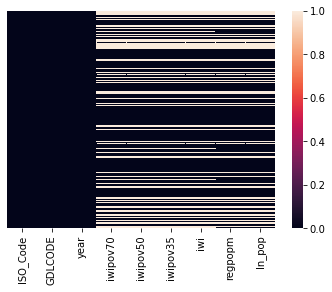

In [3]:
# all .csv files in the directoty gdl are put into seperate dataframes;
# given a title (which will be the variable name);
# then reduced to a single dataframe (gdl) and sorted
import glob
filenames = glob.glob('gdl' + "\*.csv")
filetitle = ["iwipov70", "iwipov50", "iwipov35", "iwi", "regpopm"]
files_dict = dict(zip(filenames, filetitle))
li = []
for filename in files_dict:
    df = pd.melt(pd.read_csv(filename, skipinitialspace=True),id_vars=['Country', 'ISO_Code', 'Level', 'GDLCODE', 'Region'],var_name='year', value_name=files_dict.get(filename))
    li.append(df)
    pass
gdl = reduce(lambda df1, df2: df1.merge(df2, "outer"), li)
gdl.sort_values(by=['Country', 'Region', 'year'])

# time frame reduced to 1998 to 2018
gdl['year'] = gdl['year'].apply(int)
gdl = gdl[(gdl.year > 1997) & (gdl.year < 2019)]

# countries by iso_code without chinese projects (only analyzing countries with atleast 1 project):
delete_iso_gdl = ['ARM', 'AZE', 'BFA', 'BLZ', 'BTN', 'CHN', 'DOM', 'FJI', 'GMB',
                  'GTM', 'HND', 'LBY', 'LCA', 'MDV', 'NIC', 'PAN', 'PRY', 'QAT',
                  'SAU', 'SLV', 'STP', 'SWZ', 'XKO', 'LBN', 'KWT']
gdl = gdl[~gdl['ISO_Code'].isin(delete_iso_gdl)]

# drop unnecessary columns
gdl = gdl.drop(columns=['Country', 'Region', 'Level']).reset_index()
gdl.drop('index', axis=1, inplace=True)

# add log of population & set min population to 1,000 if 0
gdl['regpopm'].values[gdl['regpopm'] == 0] = 0.001
gdl['ln_pop'] = np.where(gdl['regpopm'] > 0, np.log(gdl['regpopm']), np.nan)

# change % variable decimal format
gdl['iwipov35'] = gdl['iwipov35'] / 100
gdl['iwipov50'] = gdl['iwipov50'] / 100
gdl['iwipov70'] = gdl['iwipov70'] / 100

display(gdl.head())
display(sns.heatmap(gdl.isna(), yticklabels=False))

<h4>Adding Chinese steel production:</h4>
<p>Steel production from 1998 to 2018 sourced from the <a href="https://www.worldsteel.org/steel-by-topic/statistics/steel-statistical-yearbook.html">World Steel Association Statistical Yearbooks 2008, 2010 & 2018</a> are merged with the GDL data on year. This way all regions within the countries being studied has a value for steel production as the component of the shift-share instrument which varies annually (shift). The component which varies across regions (share; probability of recieving a project) will be created from Chinese projects data. The natural logarithm of steel production figures is calculated as a seperate variable.</p>

</p>Steel production from 2013 to 2017 are removed becuase they are not necessarily comparable with earlier data as mentioned on page 2 of the <a href="https://www.worldsteel.org/en/dam/jcr:e5a8eda5-4b46-4892-856b-00908b5ab492/SSY_2018.pdf">STEEL STATISTICAL YEARBOOK 2018</a>.</p>
    
<p>Additionally the continents from geonames is also added to the dataframe, in order have the option to separate the final dataset by continent.</p>

,ISO_Code,GDLCODE,year,iwipov70,iwipov50,iwipov35,iwi,regpopm,ln_pop,steel,ln_steel,Continent
0,AFG,AFGr101,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,11.649098,AS
1,AFG,AFGr102,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,11.649098,AS
2,AFG,AFGr103,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,11.649098,AS
3,AFG,AFGr104,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,11.649098,AS
4,AFG,AFGr105,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,11.649098,AS


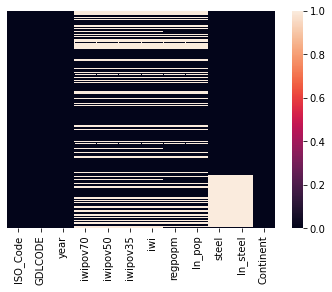

In [4]:
cnsteel = pd.read_csv("cn_steel_1998-2018.csv", thousands=',')
# reduce time frame
cnsteel = cnsteel[(cnsteel.year > 1997) & (cnsteel.year < 2014)]
# merge to gdl
gdl_steel = pd.merge(gdl, cnsteel, how="left", on='year')
# generate log steel variable
gdl_steel['ln_steel'] = np.log(gdl_steel.steel)
# add continent deatails
geonames2 = geonames1.copy()
geonames2.rename(columns={'iso_code':'ISO_Code'}, inplace=True)
gdl_steel = pd.merge(gdl_steel, geonames2[['ISO_Code', 'Continent']], how="left", on='ISO_Code')

display(gdl_steel.head())
# heatmap shows us where we have missing values
display(sns.heatmap(gdl_steel.isna(), yticklabels=False))

<h4>AidData's <a href="https://www.aiddata.org/data/geocoded-chinese-global-official-finance-dataset">Geocoded Global Chinese Official Finance</a> Dataset:</h4>
<p>
The geocoded dataset of Chinese development projects contains project location data (longitude, latitude). This is used to match projects to subnational regions defined by GDL's shapefile. Some points which lie outside of a specific region (e.g. due to offshore projects or measurement error) these points are matched with the polygon that is closest to the point. Countries with no GDL data are removed from the dataset. Leaving data for:
<ul>
    <li>4077 unique projects located within;</li>
    <li>617 unique subnational regions wihtin;</li>
    <li>104 countries.</li>
    <li>Over a 15 year period: 2000-2014.</li>
    <li>With a minimum of 86 and maximum of 411 projects per year, averaging 271.8 projects per year.</li>
</ul>
</p>

,project_id,project_location_id,precision_code,geoname_id,place_name,latitude,longitude,location_type_code,location_type_name,gazetteer_adm_code,...,source_triangulation,field_completeness,round_coded,geometry,index_right,GDLCODE,iso_code,country,region,Continent
0,1,1_2377450,1,2377450,Nouakchott,18.08581,-15.97850,PPLC,capital of a political entity,6295630|6255146|MR|NKC|2377450,...,3,6,ChinatoAfrica,POINT (-15.97850 18.08581),835.0,MRTr106,MRT,Mauritania,Trarza incl Nouakchott,AF
1,1,1_2376719,1,2376719,Sélibaby,15.15846,-12.18430,PPLA,seat of a first-order administrative division,6295630|6255146|MR|10|2376719,...,3,6,ChinatoAfrica,POINT (-12.18430 15.15846),839.0,MRTr110,MRT,Mauritania,Guidimagha,AF
2,1,1_2378538,1,2378538,Kiffa,16.61659,-11.40453,PPLA,seat of a first-order administrative division,6295630|6255146|MR|03|2378538,...,3,6,ChinatoAfrica,POINT (-11.40453 16.61659),832.0,MRTr103,MRT,Mauritania,Assaba,AF
3,3,3_2377450,1,2377450,Nouakchott,18.08581,-15.97850,PPLC,capital of a political entity,6295630|6255146|MR|NKC|2377450,...,8,8,ChinatoAfrica,POINT (-15.97850 18.08581),835.0,MRTr106,MRT,Mauritania,Trarza incl Nouakchott,AF
4,6,6_3351640,4,3351640,Província do Bié,-12.34989,17.30310,ADM1,first-order administrative division,6295630|6255146|AO|02,...,0,7,ChinatoAfrica,POINT (17.30310 -12.34989),1481.0,AGOr211,AGO,Angola,Bie,AF


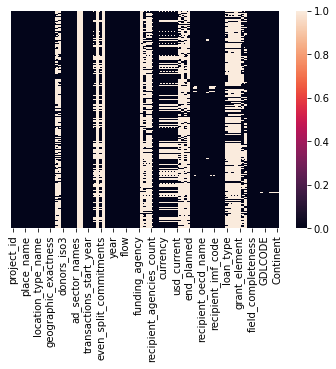

In [5]:
cnfin = pd.read_csv("GeoCoded_China_Data/all_flow_classes.csv")

# remove observations without location details
cnfin = cnfin[cnfin["latitude"].notna()]

#set geometry info and convert dataframe to geodatframe
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(cnfin["longitude"], cnfin["latitude"])]
from pyproj import CRS
crs = CRS('epsg:4326')
gdf = GeoDataFrame(cnfin, crs=crs, geometry=geometry)
cnfin = gpd.sjoin(gdf, gdl_shp, how='left', op='intersects')
cnfin.rename(columns={'GDLCode':'GDLCODE'}, inplace=True)
# iso_code will be single complete iso3 info, missings filled with iso3 from china dataset
cnfin.iso_code.fillna(cnfin.recipient_iso3, inplace=True)

# del_iso: Countries (by ISO Code) with no GDL data
del_iso = ['ATG', 'BGR', 'BHR', 'BHS', 'BRN', 'CHN', 'COK', 'CYP', 'DMA', 'FJI',
           'FSM', 'GRD', 'ISR', 'KOR', 'LCA', 'LKA', 'MDV', 'MLT', 'NZL', 'PRK',
           'ROU', 'RUS', 'SGP', 'SGP; THA', 'SYC', 'TON', 'WSM', 'LBN', 'KWT']
cnfin = cnfin[~cnfin['iso_code'].isin(del_iso)].reset_index()
cnfin.drop('index', axis=1, inplace=True)

# blanked out lines below were used to determine differences between datasets
# iso_cnfin = list(set(cnfin['iso_code']))
# iso_gdlsteel = list(set(gdl_steel['ISO_Code']))
# display(np.setdiff1d(iso_cnfin,iso_gdlsteel))
# display(np.setdiff1d(iso_gdlsteel,iso_cnfin))

# for points outside polygons from gdl_shp (e.g. offcoast projects) assign GDLCode from closest polygon:
nogdlcode = cnfin.loc[cnfin['GDLCODE'].isna()]
# create a list of closest polygon to points by GDLCode
points = [Point(xy) for xy in zip(nogdlcode["longitude"], nogdlcode["latitude"])]
# polygon's as 'strings' (wkt) to overcome rounding in multipolygons and match with correct GDLCode
gdl_poly = pd.DataFrame(zip(gdl_shp['GDLCode'], gdl_shp.geometry.apply(lambda g: g.wkt)), columns=['GDLCode', 'Poly'])
# polys as geometry dtype needed to calculate distance
polys = gdl_shp.geometry
closest_poly = []
from operator import itemgetter
for point in points:
    min_distance, min_poly = min(((poly.distance(point), poly) for poly in polys), key=itemgetter(0))
    closest_poly.append(gdl_poly[gdl_poly['Poly'] == min_poly.wkt].GDLCode.values.tolist())
    pass
import itertools
GDLCode = list(itertools.chain(*closest_poly))
project_location_id = nogdlcode.project_location_id.values.tolist()
# replace GDLCODE with dictionary key (project_location_id) value (GDLCode) pairs
di = {k:v for k, v in zip(project_location_id, GDLCode)}
for key in di.keys():
    val = di[key]
    cnfin['GDLCODE'].mask(cnfin['project_location_id'] == key, val, inplace=True)
    pass
# drop duplicate project_location_id:
cnfin.drop(1173, inplace=True)
display(cnfin.head())
display(sns.heatmap(cnfin.isna(), yticklabels=False))

<h5>Export for use beyond this notebook:</h5>

In [6]:
cnfin.to_csv('cnfin.csv')

<h5>Seperating projects in Africa, Latin America (+ Carribean) and Asia:</h5>

<p>Countries in Africa, Latin America (+ Carribean) & Asia make up 85 of the 104 countries with projects (82%) in our subset of the AidData Chinese Finance dataset.</p>
<ul>
    <li>Africa:</li>
    <ul>
        <li>2566 projects within;</li>
        <li>333 subnational regions within;</li>
        <li>48 countries.</li>
        <li>With a minimum of 42 and maximum of 291 projects per year.</li>
    </ul>
        <li>Asia:</li>
    <ul>
        <li>1072 projects within;</li>
        <li>154 subnational regions within;</li>
        <li>26 countries.</li>
        <li>With a minimum of 22 and maximum of 122 projects per year.</li>
    </ul>
    <li>Latin America (+Carribean):</li>
    <ul>
        <li>206 projects within;</li>
        <li>78 subnational regions within;</li>
        <li>18 countries.</li>
        <li>With a minimum of 1 and maximum of 49 projects per year.</li>
    </ul>
</ul>

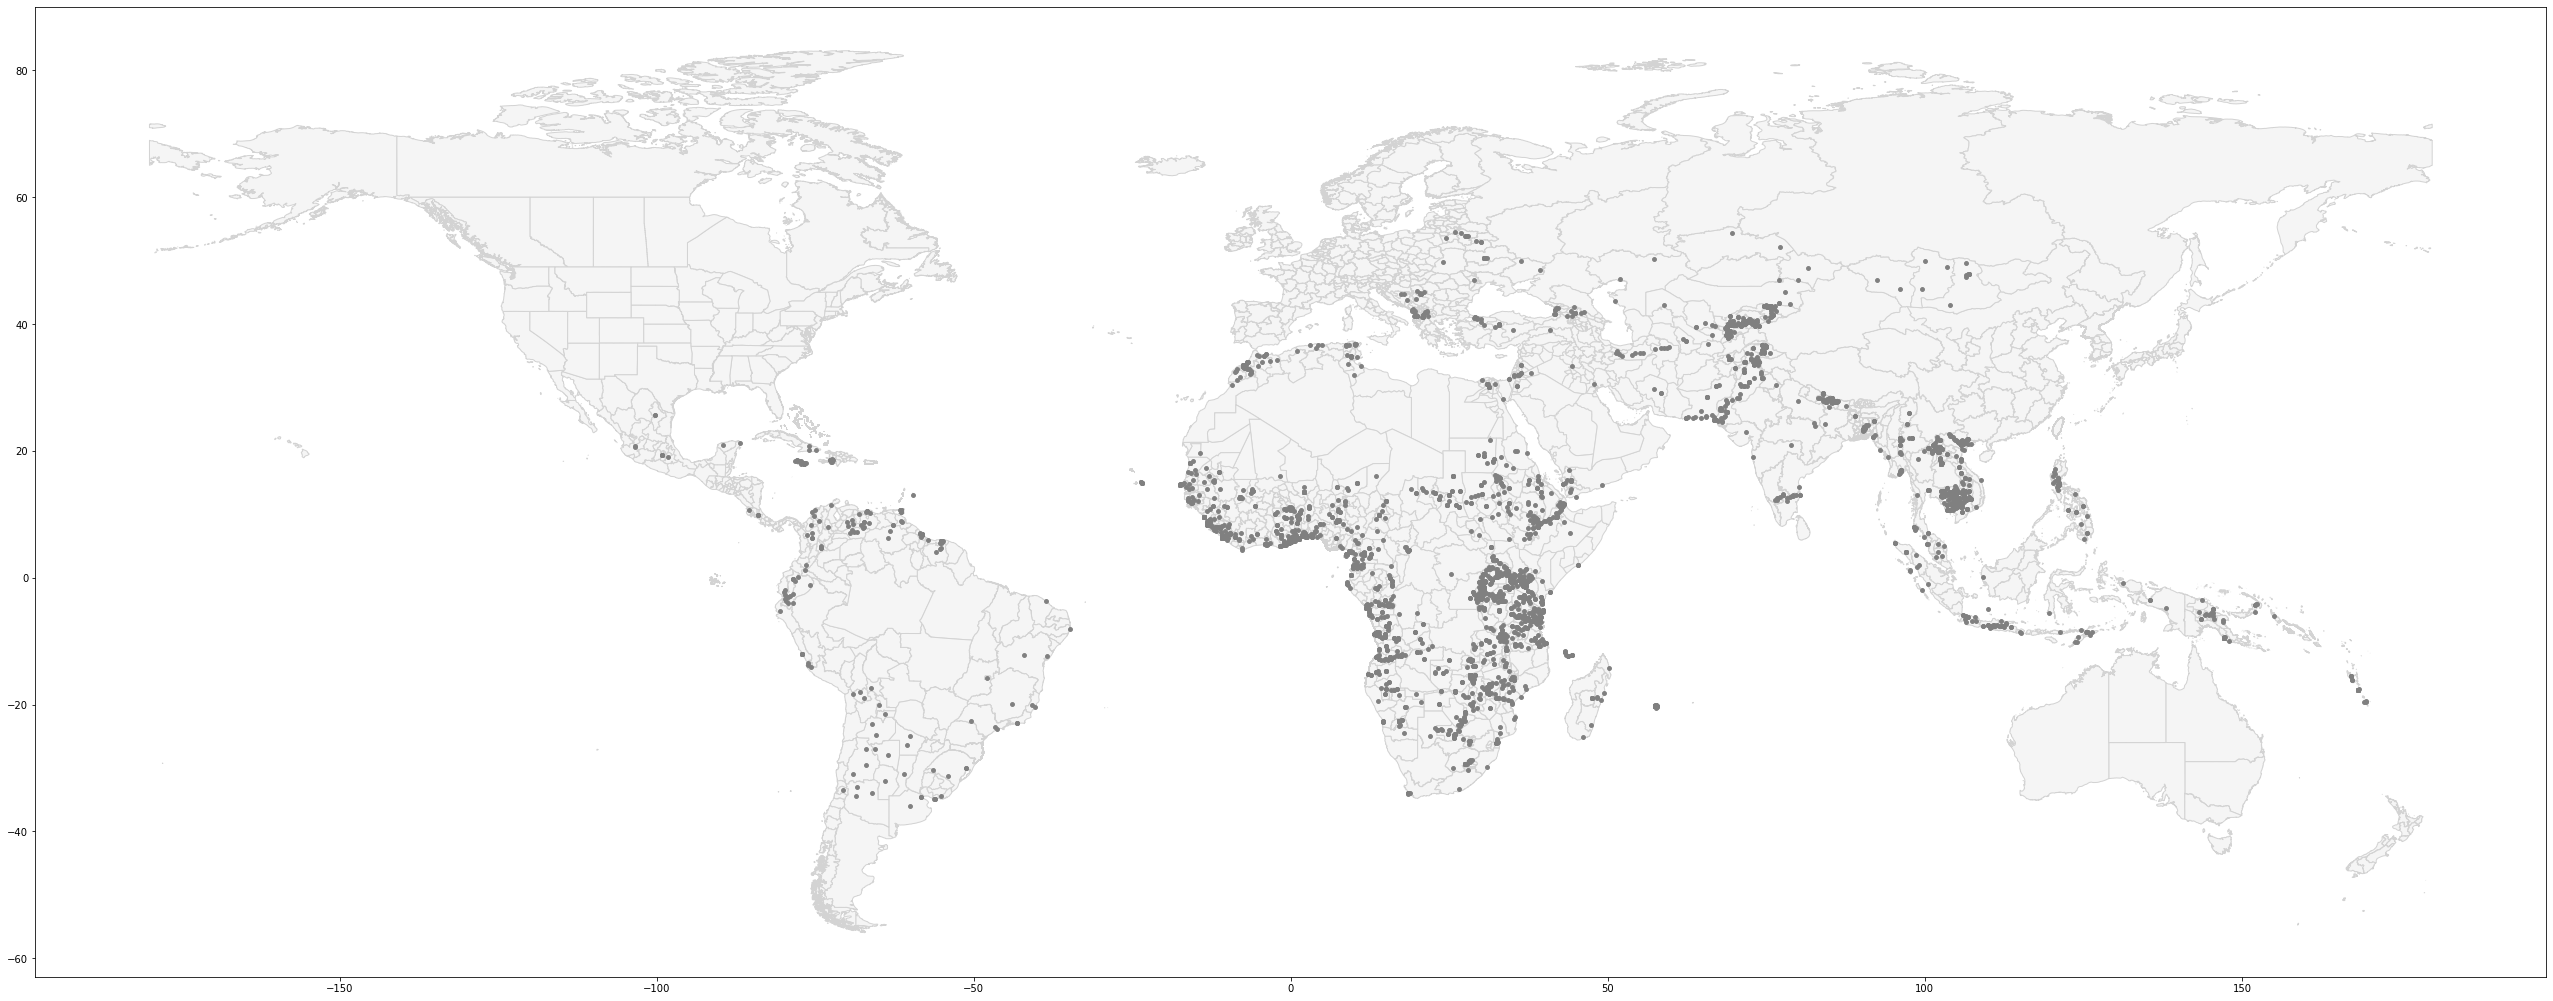

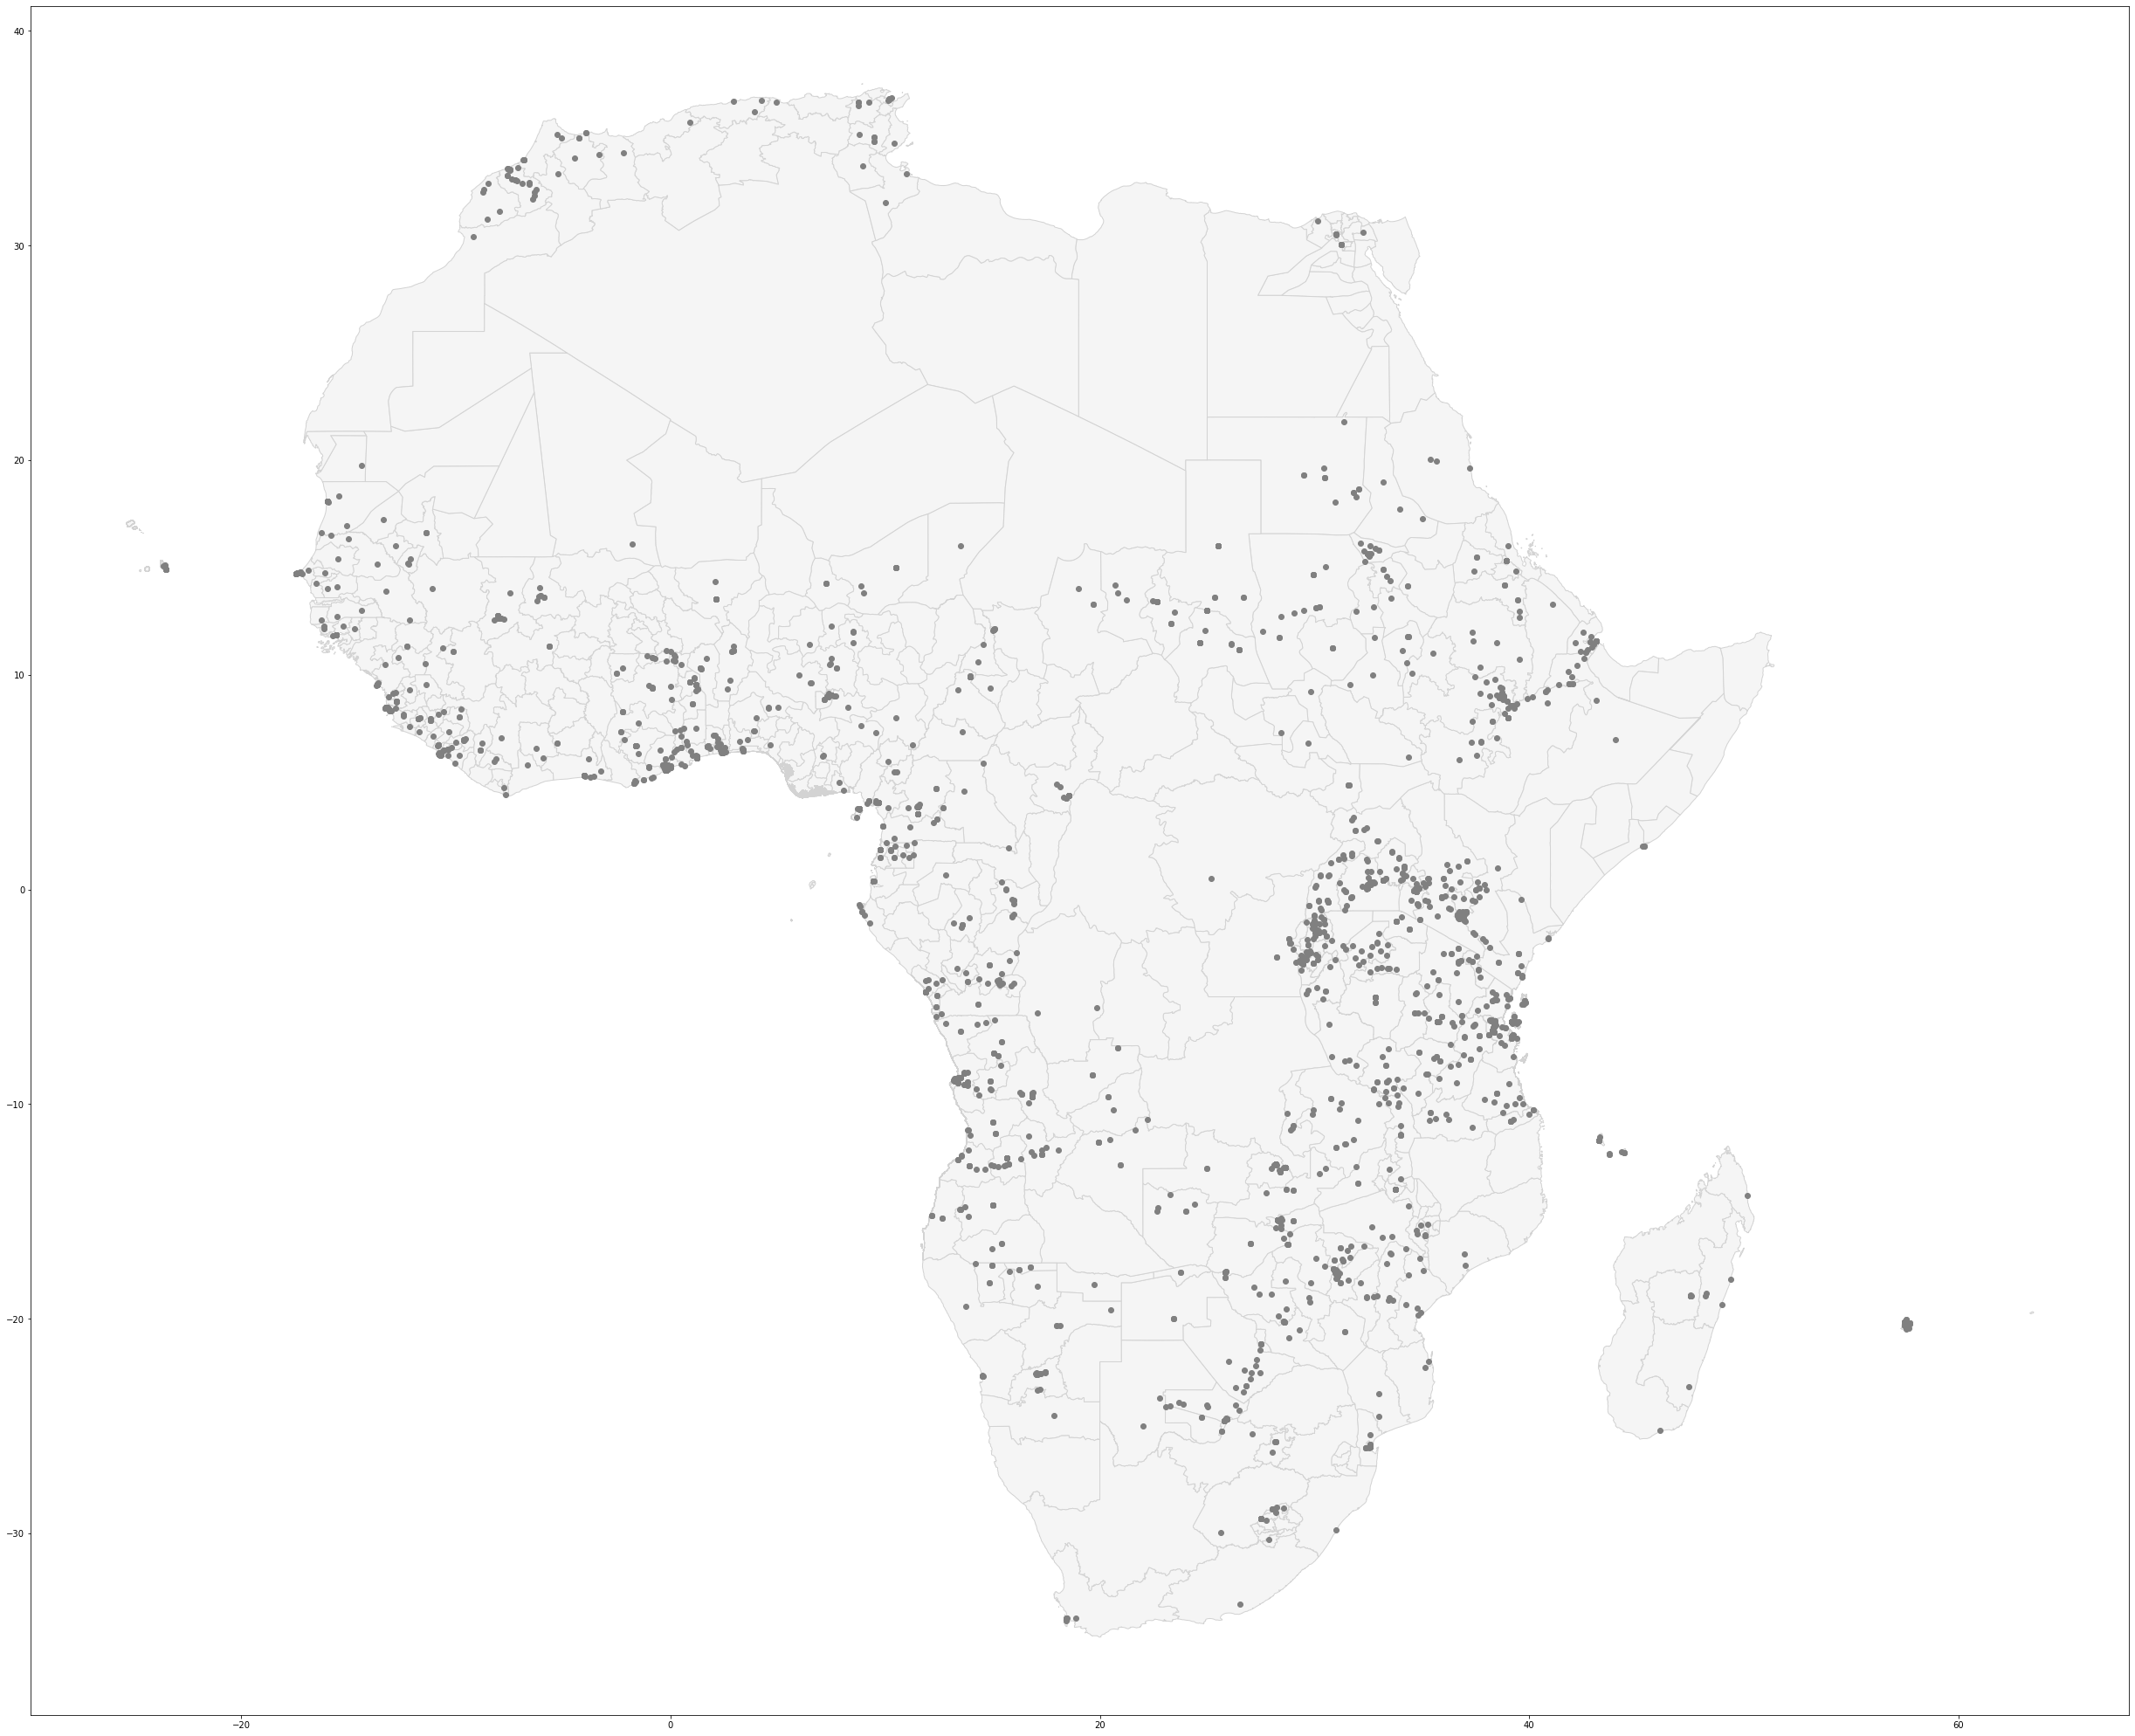

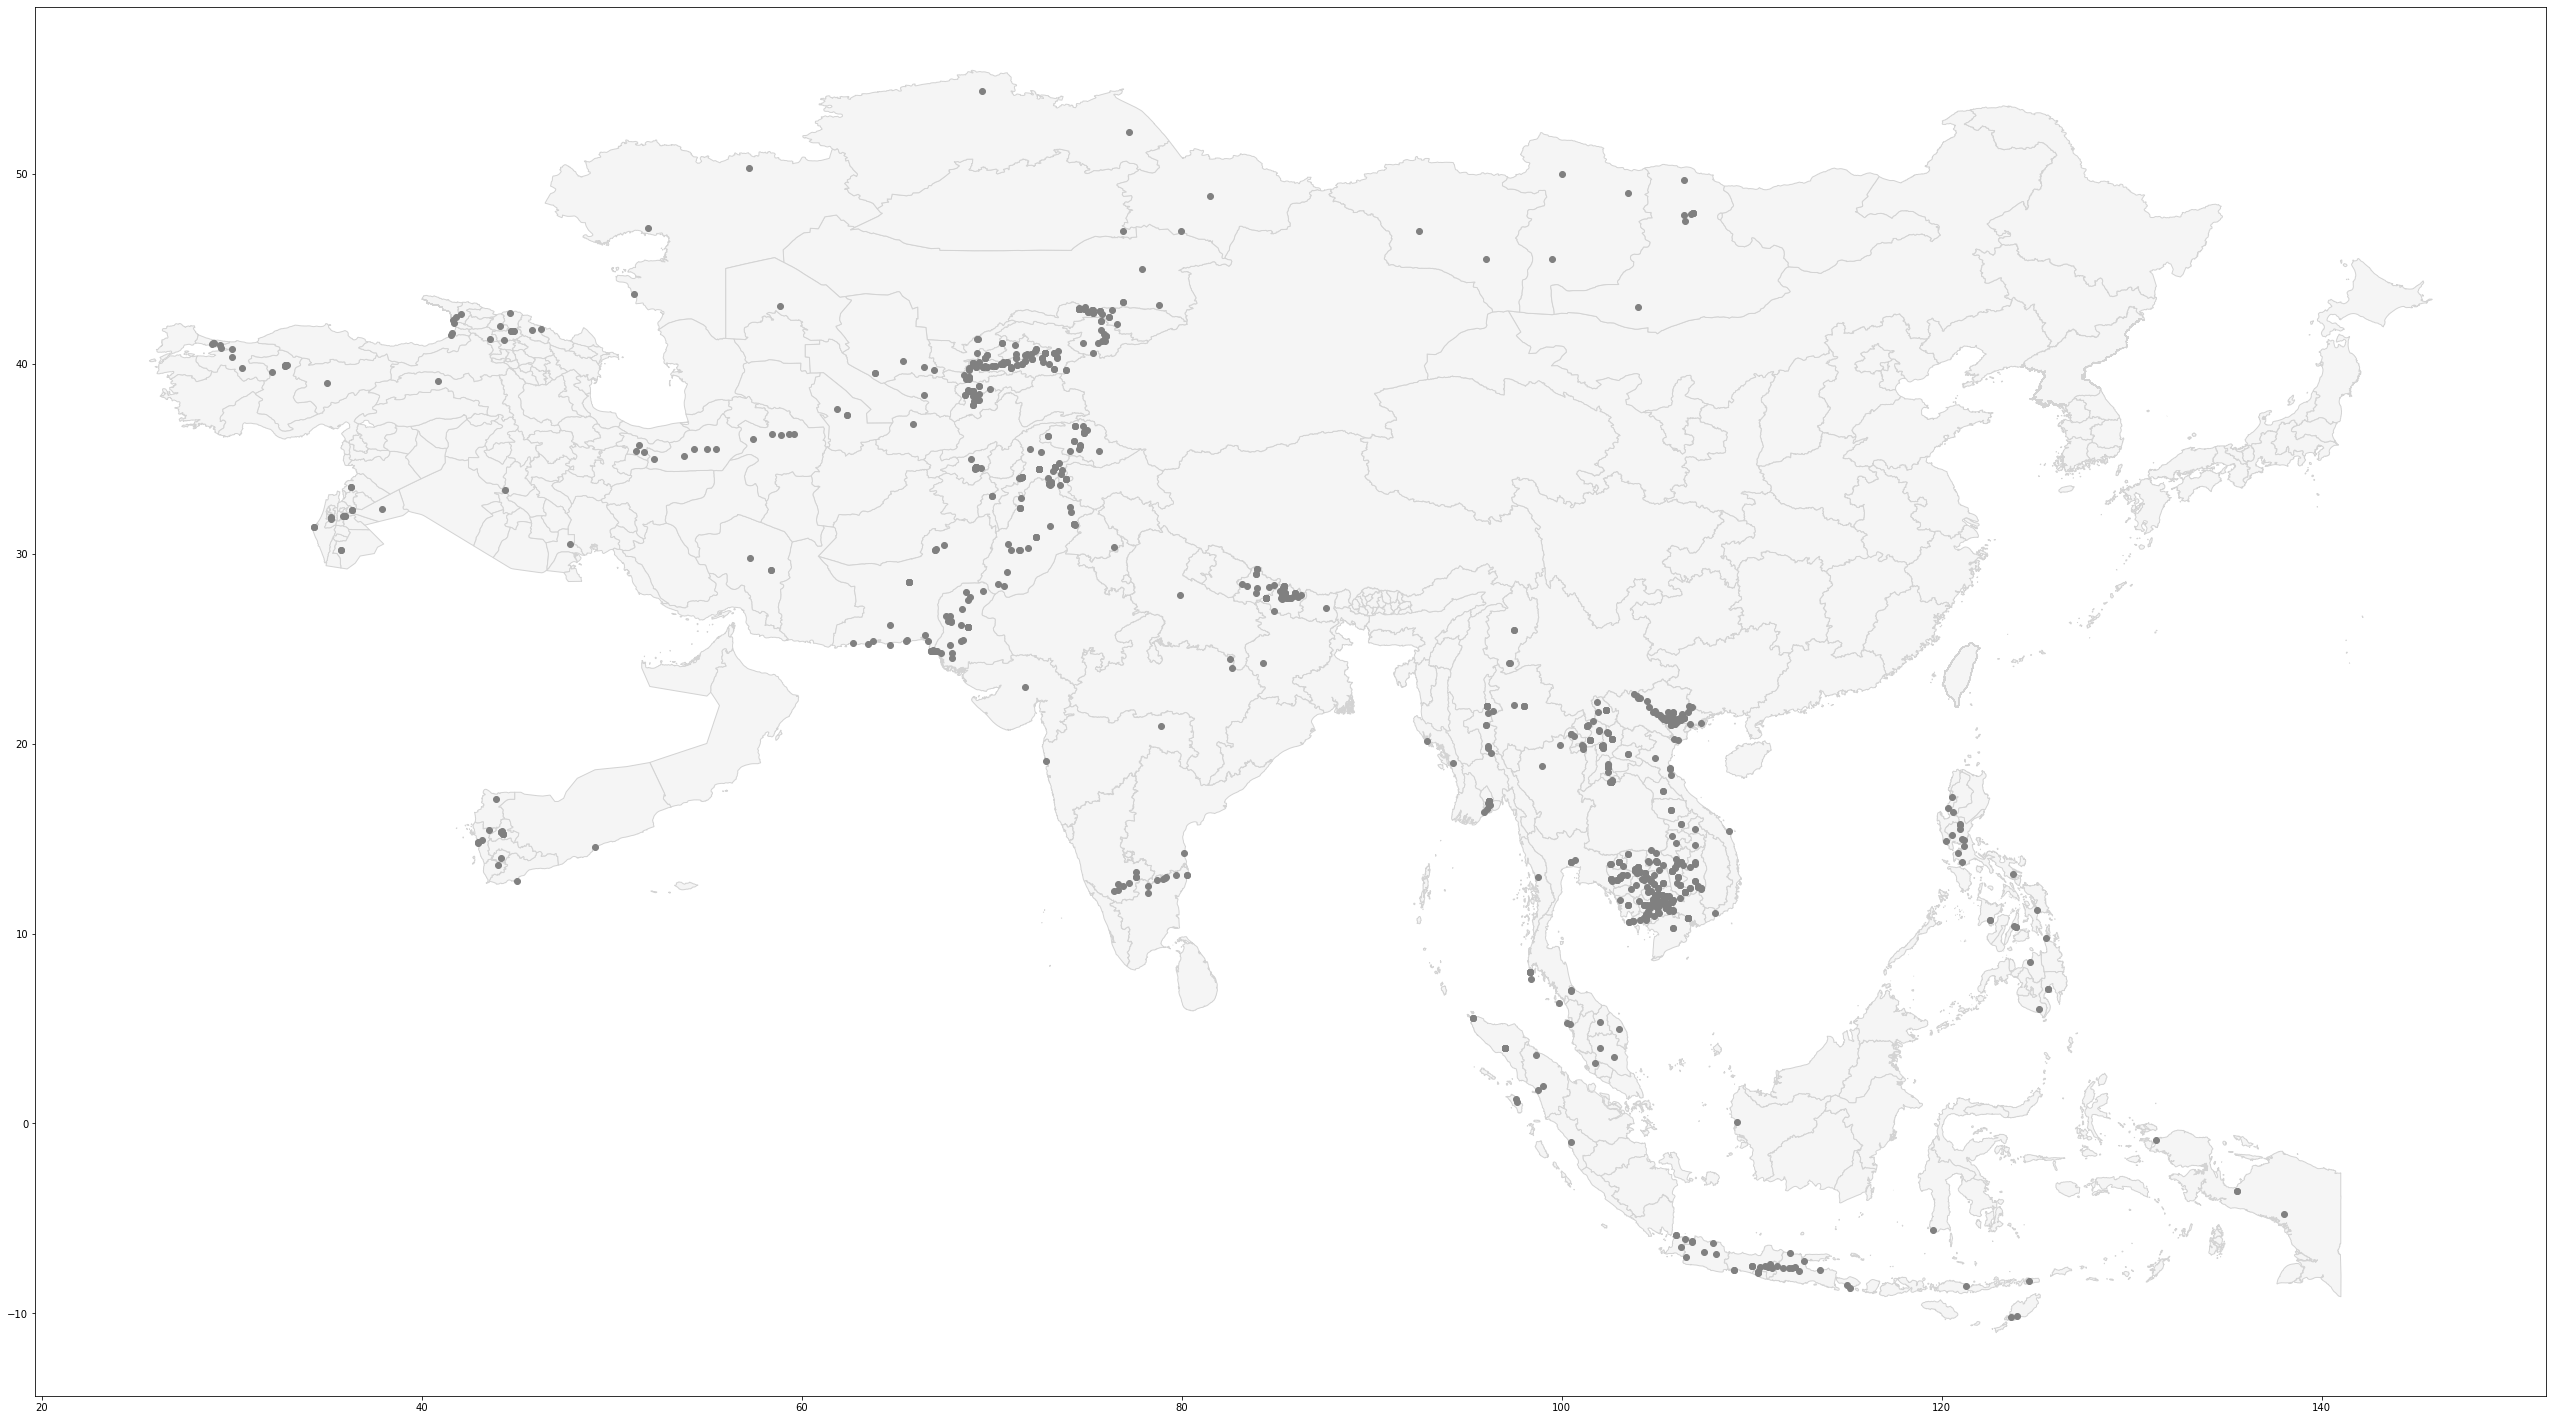

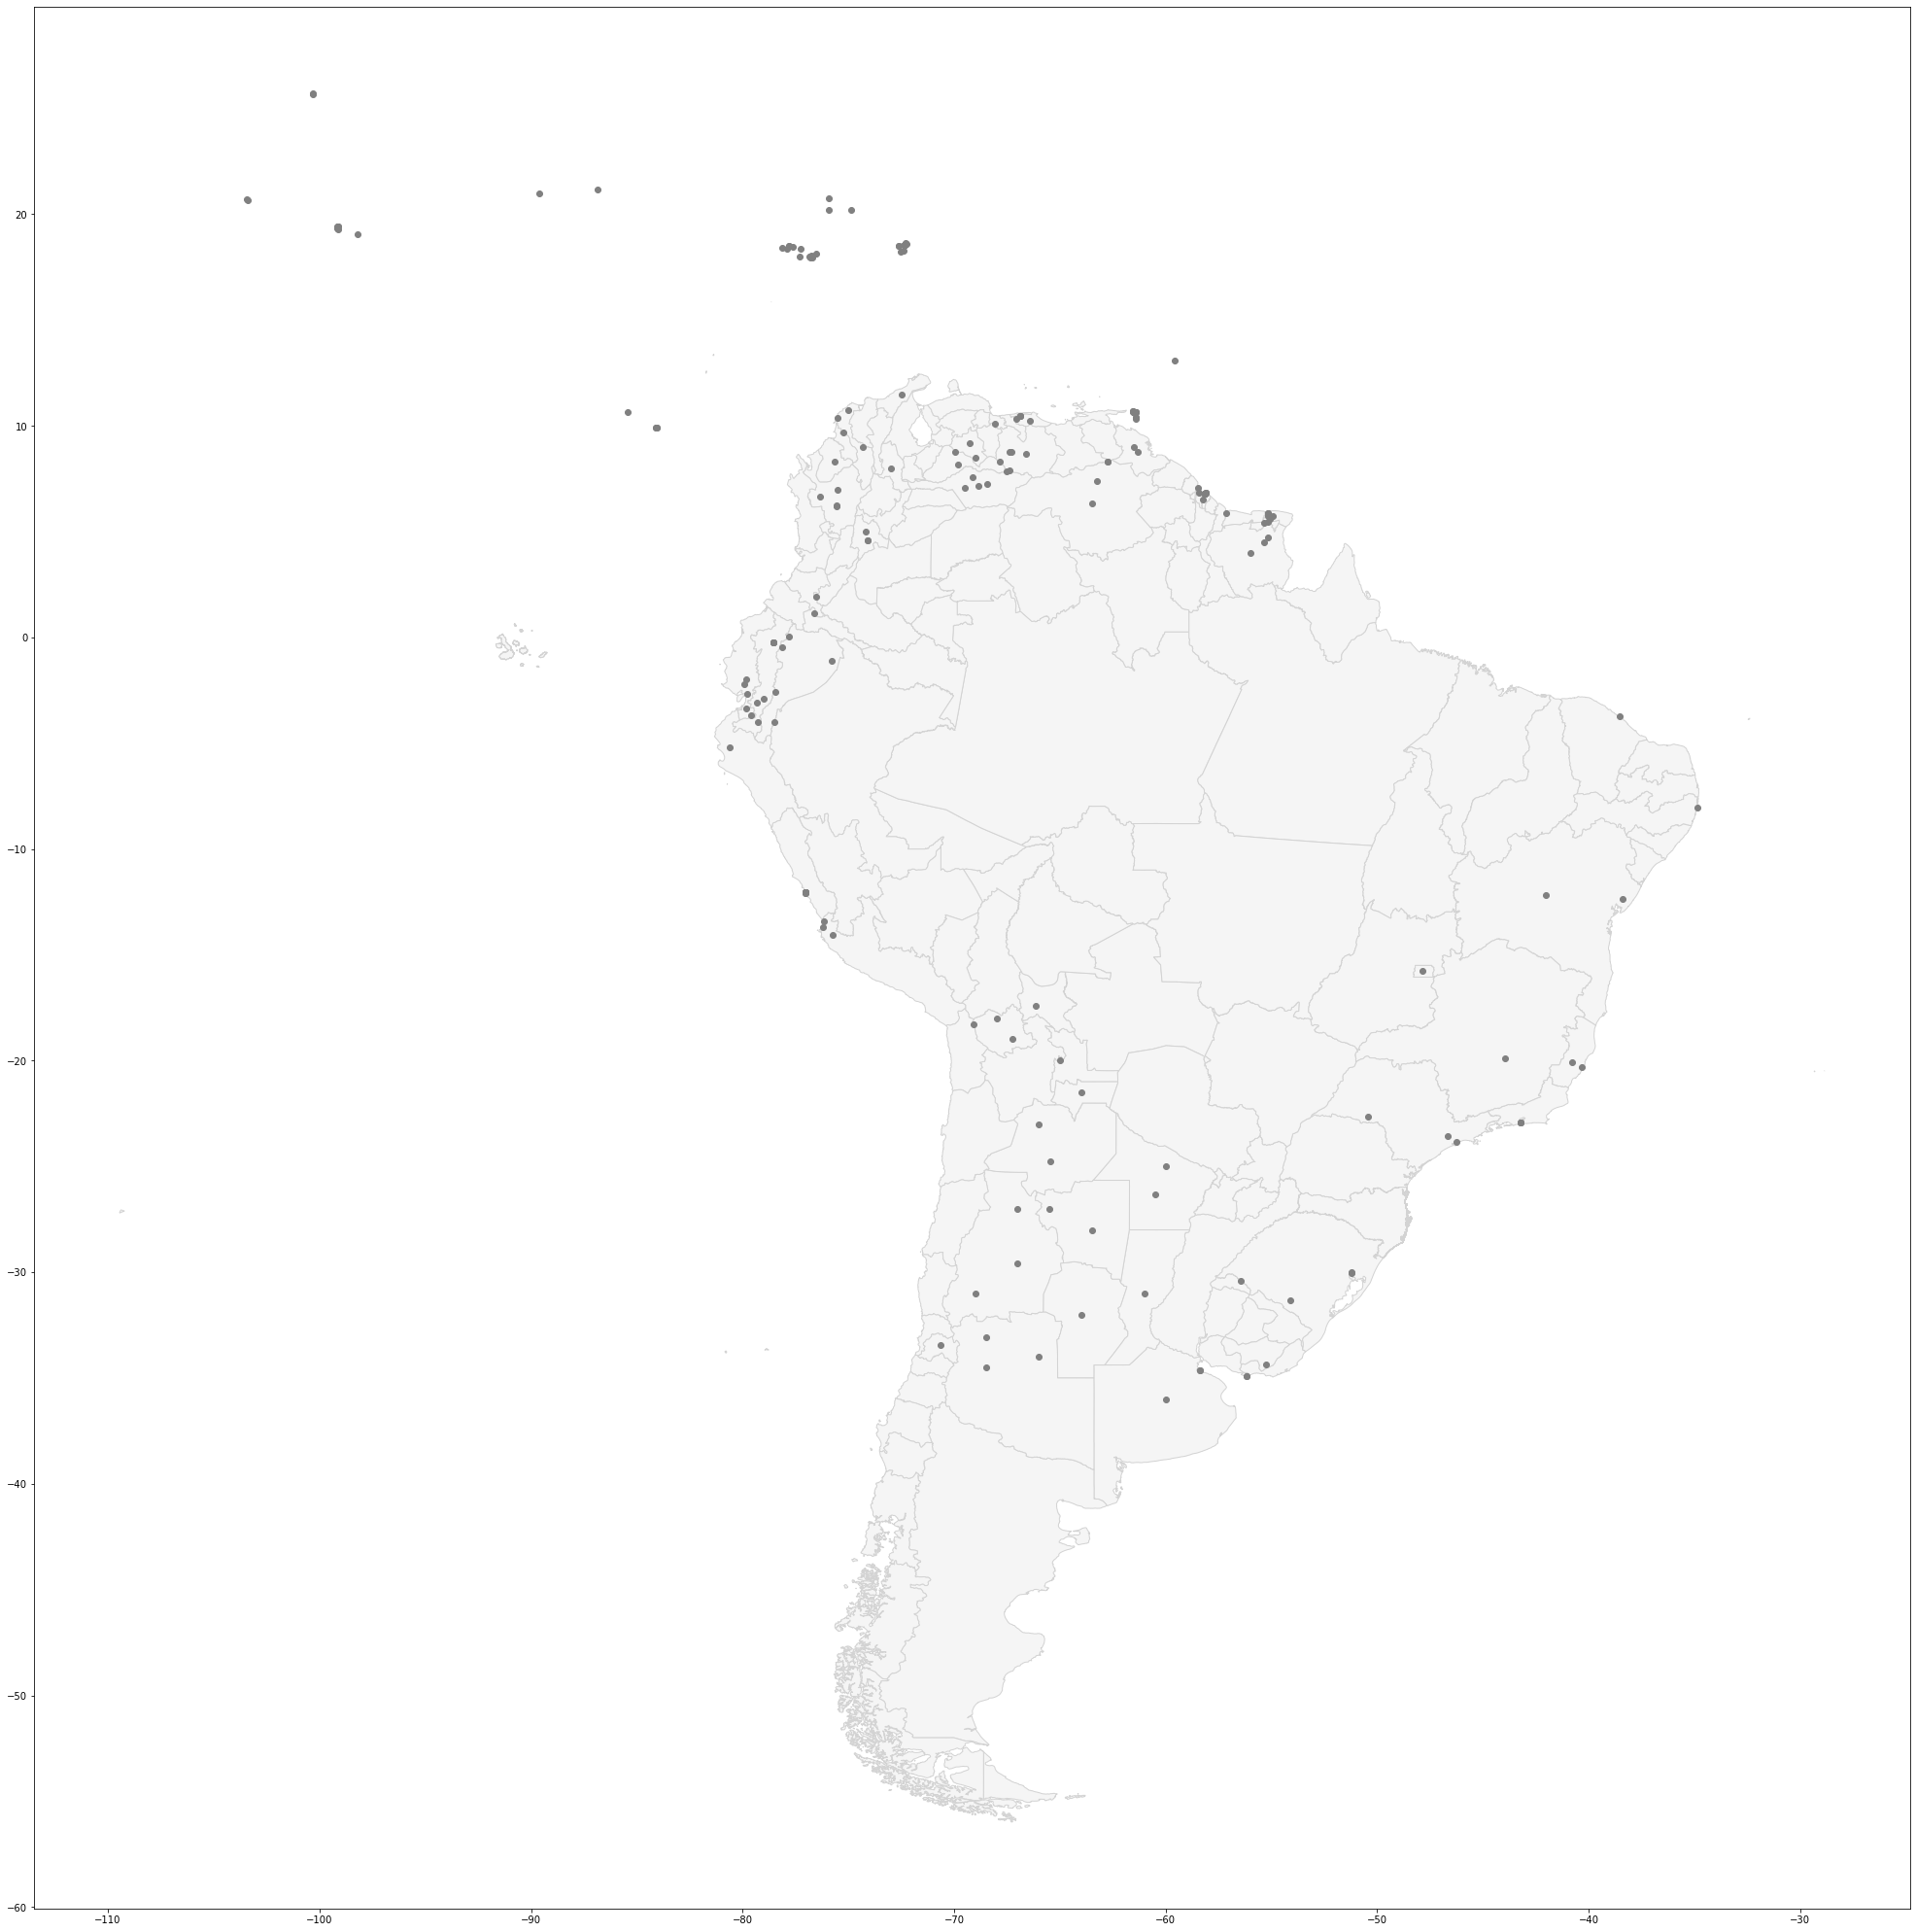

In [7]:
# splitting the chinese projects dataset by various regions
cnfin_af = cnfin[cnfin['Continent'] == 'AF']
cnfin_sa = cnfin[cnfin['Continent'].isin(['NCA', 'SA'])]
cnfin_sa = cnfin_sa[~cnfin_sa['iso_code'].isin(['USA', 'CAN'])]
cnfin_as = cnfin[cnfin['Continent'] == 'AS']

# splitting the shapefile into various regions
gdl_shp_af = gdl_shp[gdl_shp['Continent']=='AF'].copy()
gdl_shp_sa = gdl_shp[gdl_shp['Continent'].isin(['NA', 'SA'])].copy()
gdl_shp_sa = gdl_shp_sa[~gdl_shp_sa['iso_code'].isin(['USA', 'CAN'])].copy()
gdl_shp_as = gdl_shp[gdl_shp['Continent']=='AS'].copy()

# plotting project points on various maps
ax_world = gdl_shp.plot(figsize = (45, 36), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 1)
display(plt.scatter(cnfin.longitude, cnfin.latitude, s=15, marker = "o", color = "grey"))
ax_af = gdl_shp_af.plot(figsize = (45, 36), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 1)
display(plt.scatter(cnfin_af.longitude, cnfin_af.latitude, marker = "o", color = "grey"))
ax_as = gdl_shp_as.plot(figsize = (45, 36), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 1)
display(plt.scatter(cnfin_as.longitude, cnfin_as.latitude, marker = "o", color = "grey"))
ax_sa = gdl_shp_sa.plot(figsize = (45, 36), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 1)
display(plt.scatter(cnfin_sa.longitude, cnfin_sa.latitude, marker = "o", color = "grey"))

<h4>Preparing the final dataset for analysis:</h4>
<p>Each row in AidData's Geocoded Global Chinese Official Finance dataset (cnfin) is a unique project, therefore the dummy for regions with an active project will be equal to 1 for each row in the cnfin dataframe. The dummy qill be equal to 0 for regions-year combinations that do not have an active project but are within the group of countries that have atleast 1 region in 1 year with a project. These regions are within the gdl_steel dataframe made earlier, therefore after merging the NA will be assigned 0s. With this setup we will be testing all of the countries for which we have a poverty measure (GDL's IWI measure) and that have atleast 1 active project in one of their regions in one year.</p>
<p>A dataframe with the count of projects within each region per year is created below, including the count of projects by sector and flow class. Additionally a dummy variable is created for each sector and flow type indicating the presence of atleast 1 project. Allowing for analysis with a count of projects as well as a binary indicator of the presence of development projects.</p>

In [8]:
projects = cnfin[['GDLCODE', 'year']].copy()
# the dummay variable for all projects equal to 1 for each row in cnfin (0s assigned later)
projects['total'] = 1
# generate dataframe with dummies per sector and flow class
crs_sector = pd.get_dummies(cnfin['crs_sector_name'])
flow_class = pd.get_dummies(cnfin['flow_class'])
# merge all dummmy dataframes
projects = pd.concat([projects, crs_sector, flow_class], axis=1)
# give short variable names
shortname = ['GDLCODE', 'year', 'total', 'debt', 'agri', 'bank', 'business', 'comms', 'food_aid', 'educ', 'emergency', 
             'energy', 'budget', 'environment', 'civil', 'health', 'industry', 'commod', 
             'multisector', 'social_infra', 'pop_policy', 'ngo_support', 'trade_tourism', 
             'transport', 'unspecified', 'water', 'women', 'oda', 'oof', 'vague']
rename_cols = dict(zip(projects.columns,shortname))
projects.columns = projects.columns.map(rename_cols)
# aggregate dummies to get project counts by each region (GDLCODE) year combination
projects = projects.pivot_table(index = shortname[:2], values = shortname[2:], aggfunc = 'sum').reset_index()
# generate binary variables if count is > 0 = 1 else 0
for column in projects.columns[2:]:
    projects[column+'_d'] = np.where(projects[column]>=1, 1, 0)
    pass
projects.head()

,GDLCODE,year,agri,bank,budget,business,civil,commod,comms,debt,...,oof_d,pop_policy_d,social_infra_d,total_d,trade_tourism_d,transport_d,unspecified_d,vague_d,water_d,women_d
0,AFGr101,2001,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,AFGr101,2002,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,AFGr101,2003,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,AFGr101,2006,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,AFGr101,2008,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


<p>Pivot table's of the dummies & counts dataframe above (projects) are used to generate a dataframe with each region's probability of receiving a Chinese project between 2000-2014, aka the share component of the shift-share instrument. The total number of years that a region received a project is aggregated and then divided by 15. This is done for each crs sector and flow class and the resulting seperate dataframes are merged. This gives each region a probability of receiving a project in total and by sector & flow class.</p>

In [9]:
dummies = list(projects.columns[2:30])
# change the order so that total is first column (as it has the greatest number of observations so;
# sectors and flow class probabilities with lower observations can be merged using 'append' 
dummies[21], dummies[0] = dummies[0], dummies[21]
pivot = []
for i in dummies:
    p1 = projects.pivot_table(index = ['GDLCODE', 'year'], values = i, aggfunc = 'sum').reset_index()
    p1 = p1[(p1[i] > 0)]
    p = p1.pivot_table(index = 'GDLCODE', values = 'year', aggfunc = pd.Series.nunique).reset_index()
    p['year'] = p['year'] / 15
    p.rename(columns = {'year':i+'_p'}, inplace = True) 
    pivot.append(p)
    pass
p_data = reduce(lambda p1, p2: p1.merge(p2, "left"), pivot)
p_data.head()

,GDLCODE,total_p,bank_p,budget_p,business_p,civil_p,commod_p,comms_p,debt_p,educ_p,...,oof_p,pop_policy_p,social_infra_p,agri_p,trade_tourism_p,transport_p,unspecified_p,vague_p,water_p,women_p
0,AFGr101,0.600000,NaN,0.066667,NaN,0.2,NaN,0.066667,NaN,0.266667,...,0.133333,NaN,0.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFGr104,0.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGOr201,0.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,...,0.133333,NaN,NaN,NaN,NaN,0.066667,NaN,NaN,NaN,NaN
3,AGOr202,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,...,0.066667,NaN,NaN,NaN,NaN,0.066667,NaN,NaN,NaN,NaN
4,AGOr203,0.266667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.266667,NaN,NaN,NaN,NaN,0.133333,NaN,NaN,0.133333,NaN


<p>The project counts & dummy dataframe (projects) and the dataframe containing probabilities of a region receiving a project (p_data) are ready to be seperately merged with the socio-economic indicators data (gdl_steel). This ensures that each observation (row) in the dataset has data for the respective region's probability of receiving a project, even for the years in which a region did not receive a project. This is important for our intrumental variable strategy because the share component is the component of the shift-share instrument which varies cross-sectionally.</p>

<h5>Project amounts:</h5>

<p>The amounts recorded in the Gecoded Global Chinese Official Finance Dataset are not available for all observations and their reliability is questioned, we can add them to our final dataset and cautiously provide regression results using amounts as a robustness check.</p>
<p>Below we create 4 dataframes with the summed amount of project values within a region per year broken down by:</p>
<ul>
    <li>Total projects;</li>
    <li>OOF-Like project;</li>
    <li>ODA-Like projects;
    <li>Transport sector projects.</li>
</ul>

In [10]:
# generate dataframes for amounts by sector and flow class
amounts = cnfin.copy()
amounts['even_split_commitments'] = amounts['even_split_commitments'] / 1000000
amount_total = amounts.pivot_table(index = ['GDLCODE', 'year'], values = 'even_split_commitments', aggfunc = 'sum').sort_values(by=['even_split_commitments'], ascending=False).reset_index()
amounts_by_flow = amounts.pivot_table(index = ['GDLCODE', 'year', 'flow_class'], values = 'even_split_commitments', aggfunc = 'sum').sort_values(by=['even_split_commitments'], ascending=False).reset_index()
amount_oof = amounts_by_flow[amounts_by_flow['flow_class'] == 'OOF-like'].drop('flow_class', axis=1)
amount_oda = amounts_by_flow[amounts_by_flow['flow_class'] == 'ODA-like'].drop('flow_class', axis=1)
amounts_by_sector = amounts.pivot_table(index = ['GDLCODE', 'year', 'crs_sector_name'], values = 'even_split_commitments', aggfunc = 'sum').sort_values(by=['even_split_commitments'], ascending=False).reset_index()
amount_transport = amounts_by_sector[amounts_by_sector['crs_sector_name'] == 'Transport and Storage'].drop('crs_sector_name', axis=1)

# rename the variables (in a slightly roundabout way)
amount_dfs = [amount_total, amount_oof, amount_oda, amount_transport]
names = ['amount_total', 'amount_oof', 'amount_oda', 'amount_transport']
k = 0
for df in amount_dfs:
    df.rename(columns={'even_split_commitments':names[k]}, inplace=True)
    k = k + 1
    pass

# merge the amount dataframes
amounts = reduce(lambda  left,right: pd.merge(left,right,on=['GDLCODE', 'year'], how='left'), amount_dfs)
# round amounts
for name in names:
    amounts[name] = amounts[name].round(2)
    pass

amounts.head()

,GDLCODE,year,amount_total,amount_oof,amount_oda,amount_transport
0,PAKr102,2014,8221.05,6251.00,430.87,1539.19
1,TKMr106,2009,5428.40,5428.40,NaN,NaN
2,BRAr120,2010,4401.94,4401.94,NaN,NaN
3,BLRr105,2013,3076.15,3050.26,25.89,25.89
4,LAOr103,2012,2541.69,2541.69,NaN,2541.69


<h4>Merging all prepared dataframes to the final dataset:</h4>
The following cleaned and prepared dataframes are merged, in the order below. To complete the final dataset for the analysis using Stata:
<ol>
    <li>Global Data Lab's subnational socio-economic indicators dataframe: gdl_steel</li>
    <li>Project counts and dummies dataframe: projects</li>
    <li>Predetermined regional probability of receiving a project between 2000-2014: p_data</li>
    <li>Summed project values by region per year: amounts_total/_by_oof/_by_oda/_by_transport</li>
</ol>

,ISO_Code,GDLCODE,year,iwipov70,iwipov50,iwipov35,iwi,regpopm,ln_pop,steel,...,trade_tourism_p,transport_p,unspecified_p,vague_p,water_p,women_p,amount_total,amount_oof,amount_oda,amount_transport
0,AFG,AFGr101,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFG,AFGr102,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AFG,AFGr103,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFG,AFGr104,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFG,AFGr105,1998,NaN,NaN,NaN,NaN,NaN,NaN,114588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25237,CUB,CUBr104,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25238,CUB,CUBr103,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25239,CUB,CUBr102,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25240,CUB,CUBr101,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


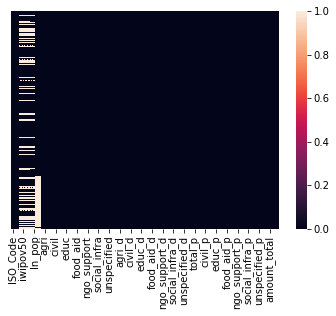

In [11]:
# merge gdl indicators & steel to projects counts & dummies
data = pd.merge(gdl_steel, projects, how="left", on=['GDLCODE', 'year'])
# merge the probabilities dataframe
data = pd.merge(data, p_data, how="left", on=['GDLCODE'])
# merge project values by sector and flow class
data = pd.merge(data, amounts, how="left", on=['GDLCODE', 'year'])
# assign regions that never recieve a project with 0 for dummies, counts, probabilities and values
fill_nan = data.columns[12:]
for column in fill_nan:
    data.fillna({column:0}, inplace=True)
    pass

display(data)
display(sns.heatmap(data.isna(), yticklabels=False))

<h4>Exports:</h4>
<p>Final dataset is exported in .dta for analysis in Stata. Analysis can be run using analysis.do found in the repository.</p>
<p>The dataset is also saved in .csv format</p>

In [12]:
#data.to_stata('data.dta')
#data.to_csv('data.csv')